In [1]:
# run note book under /MUKit
%cd ..

/media/volume/mmcv/MUKit


/home/exouser/miniconda3/envs/mu/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
%load_ext autoreload
%autoreload 2

import requests
import torch
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from pathlib import Path

from transformers import CLIPProcessor, CLIPModel
from accelerate import Accelerator

# from clip import open_clip
# from clip.open_clip import build_zero_shot_classifier
# from clip.a0_eval_celeba import run_name, CELEB_NAMES, CELEB_TEMPLATES
# from clip.a0_eval_imagenet import run, IMAGENET_CLASSNAMES, OPENAI_IMAGENET_TEMPLATES
# from clip.open_clip.zero_shot_metadata import SIMPLE_IMAGENET_TEMPLATES, IMAGENET_CLASSNAMES
# , SIMPLE_IMAGENET_TEMPLATES

/home/exouser/miniconda3/envs/mu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
accelerator = Accelerator()
device = accelerator.device

In [5]:
from functools import partial
from itertools import islice
from typing import Callable, List, Optional, Sequence, Union

import torch
import torch.nn.functional as F


def batched(iterable, n):
    """Batch data into lists of length *n*. The last batch may be shorter.
    NOTE based on more-itertools impl, to be replaced by python 3.12 itertools.batched impl
    """
    it = iter(iterable)
    while True:
        batch = list(islice(it, n))
        if not batch:
            break
        yield batch


def build_zero_shot_classifier(
        model,
        tokenizer,
        classnames: Sequence[str],
        templates: Sequence[Union[Callable, str]],
        num_classes_per_batch: Optional[int] = 10,
        device: Union[str, torch.device] = 'cpu',
        use_tqdm: bool = False,
):
    """ Build zero-shot classifier weights by iterating over class names in batches
    Args:
        model: CLIP model instance
        tokenizer: CLIP tokenizer instance
        classnames: A sequence of class (label) names
        templates: A sequence of callables or format() friendly strings to produce templates per class name
        num_classes_per_batch: The number of classes to batch together in each forward, all if None
        device: Device to use.
        use_tqdm: Enable TQDM progress bar.
    """
    assert isinstance(templates, Sequence) and len(templates) > 0
    assert isinstance(classnames, Sequence) and len(classnames) > 0
    use_format = isinstance(templates[0], str)
    num_templates = len(templates)
    num_classes = len(classnames)
    if use_tqdm:
        import tqdm
        num_iter = 1 if num_classes_per_batch is None else ((num_classes - 1) // num_classes_per_batch + 1)
        iter_wrap = partial(tqdm.tqdm, total=num_iter, unit_scale=num_classes_per_batch)
    else:
        iter_wrap = iter

    def _process_batch(batch_classnames):
        num_batch_classes = len(batch_classnames)
        texts = [template.format(c) if use_format else template(c) for c in batch_classnames for template in templates]
        inputs = tokenizer(texts, padding=True, return_tensors="pt", 
                        truncation=True,      # Enable truncation
                        max_length=77         # Set the maximum length to 77 tokens
                        ).to(device)

        # class_embeddings = model.encode_text(texts, normalize=True)
        class_embeddings = model.get_text_features(**inputs)
        class_embeddings = class_embeddings.reshape(num_batch_classes, num_templates, -1).mean(dim=1)
        class_embeddings = class_embeddings / class_embeddings.norm(dim=1, keepdim=True)
        class_embeddings = class_embeddings.T
        return class_embeddings

    with torch.no_grad():
        if num_classes_per_batch:
            batched_embeds = [_process_batch(batch) for batch in iter_wrap(batched(classnames, num_classes_per_batch))]
            zeroshot_weights = torch.cat(batched_embeds, dim=1)
        else:
            zeroshot_weights = _process_batch(classnames)
    return zeroshot_weights

In [6]:
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
# data_root = Path("/home/zcai032/unlearn/MUKit/clip/data/celeba")
data_root = Path("data/celeba")
file_image_name = data_root / "list_identity_celeba.txt"
with open(file_image_name, 'r') as f:
    # Read the file line by line
    lines = f.readlines()

# Initialize an empty dictionary
jpg_dict = defaultdict(list)

# Iterate over the lines starting from the second line (index 1)
for line in lines[2:]:
    # Split the line into image_id and identity_name
    image_id, identity_name = line.strip().split()
    # Add the image_id and identity_name to the dictionary
    jpg_dict[identity_name].append(image_id)

name_set = set(jpg_dict.keys())
name_list = tuple(sorted(name_set))
CELEB_NAMES = [name.replace('_', ' ') for name in name_list]
CELEB_TEMPLATES = (
    lambda c: f'{c}.',
    # lambda c: f'a photo of {c}.',
    # lambda c: f'an image of {c}.',
)


def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


def run_name(model, classifier, name, processor, device):
    
    label = name_list.index(name)

    top1, top5, n = 0., 0., 0.
    for image_id in jpg_dict[name]:
        image_path = data_root / "img_align_celeba" / image_id
        image = Image.open(image_path).convert("RGB")
        
        # image = preprocess(image).unsqueeze(0)
        # image = image.to(device)
        target = torch.tensor([label]).to(device)
        # target = target.to(device)

        inputs = processor(text=[CELEB_TEMPLATES[0](name)], images=image, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            # output = model(image=image)
            outputs = model(**inputs)


        # image_features = output['image_features'] if isinstance(output, dict) else output[0]
        image_features = outputs.image_embeds
        logits = 100. * image_features @ classifier
        # measure accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1 += acc1
        top5 += acc5
        # n += image.size(0)
        n += 1

    top1 = (top1 / n)
    top5 = (top5 / n)
    return top1, top5


def run_imagenet(model, classifier, dataloader, device, args):
    
    top1, top5, n = 0., 0., 0.
    for images, target in tqdm(dataloader, unit_scale=args.batch_size):
    
        target = target.to(device)
        with torch.no_grad():
            image_features = model.get_image_features(images.pixel_values[0].to(device))
        # inputs = processor(text=[CELEB_TEMPLATES[0](name)], images=image, return_tensors="pt", padding=True).to(device)
        # with torch.no_grad():
        #     # output = model(image=image)
        #     outputs = model(**inputs)

        # image_features = output['image_features'] if isinstance(output, dict) else output[0]
        # image_features = outputs.image_embeds
        logits = 100. * image_features @ classifier
        # measure accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1 += acc1
        top5 += acc5
        # n += image.size(0)
        n += 1

    top1 = (top1 / n)
    top5 = (top5 / n)
    return top1, top5

In [7]:
clip_model_id = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
model_clip = CLIPModel.from_pretrained(clip_model_id)
processor_clip = CLIPProcessor.from_pretrained(clip_model_id)

In [8]:
model_clip.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 1024)
      (position_embedding): Embedding(77, 1024)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-23): 24 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,), e

In [9]:
model_clip_pretrained = deepcopy(model_clip)

In [10]:
def build_classifiers(model_clip):
    classifier_celeb = build_zero_shot_classifier(
            model_clip,
            tokenizer=processor_clip.tokenizer,
            classnames=CELEB_NAMES,
            templates=CELEB_TEMPLATES,
            num_classes_per_batch=10,
            device=device,
            use_tqdm=True,
        )

    # classifier_imagenet = build_zero_shot_classifier(
    #         model_clip,
    #         tokenizer=processor_clip.tokenizer,
    #         classnames=CELEB_NAMES,
    #         templates=SIMPLE_IMAGENET_TEMPLATES,
    #         num_classes_per_batch=10,
    #         device=device,
    #         use_tqdm=True,
    #     )
    # return classifier_celeb, classifier_imagenet
    return classifier_celeb

# classifier_celeb, classifier_imagenet = build_classifiers(model_clip)
classifier_celeb = build_classifiers(model_clip)

  0%|          | 0/10180 [00:00<?, ?it/s]

100%|██████████| 10180/10180 [00:16<00:00, 618.27it/s]


In [9]:
# # classifier_celeb = torch.load("/home/eegrad/zcai/unlearn/MUKit/celeba_classifier.pth")
# # classifier_imagenet = torch.load("/home/eegrad/zcai/unlearn/MUKit/imagenet_classifier.pth")

# from clip.training.data import get_imagenet
# from clip.training.params import parse_args
# args = parse_args([])
# # args.imagenet_val = '/data/SalmanAsif/ImageNet/val'
# args.imagenet_val = '/home/zcai032/unlearn/MUKit/clip/data/imagenet/val'
# args.device = device
# args.batch_size = 32
# preprocess_fns = (processor_clip.image_processor, processor_clip.image_processor)
# split = 'val'
# data_imagenet = get_imagenet(args, preprocess_fns, split, ratio=0.05)

In [10]:
name = "Elon_Musk"
# name = "Mark_Zuckerberg"
top1, top5 = run_name(model_clip, classifier_celeb, name, processor_clip, device)
print(f"[celeb] top1: {top1*100:.2f}%, top5: {top5*100:.2f}%")


# top1, top5 = run_imagenet(model_clip, classifier_imagenet, data_imagenet.dataloader, device, args)
# print(f"[imagenet] top1: {top1*100:.2f}%, top5: {top5*100:.2f}%")


/home/exouser/miniconda3/envs/mu/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
/tmp/ipykernel_10826/3653253312.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


[celeb] top1: 100.00%, top5: 100.00%


In [11]:
def plot_iamge_text_matrix(similarity, texts, original_images, title="Cosine similarity between text and image features", save_path="CLIP_similarity.png"):
    count = len(texts)
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    # plt.colorbar()
    plt.yticks(range(count), texts, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(original_images):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])

    plt.title(title, size=20)
    plt.tight_layout()
    # plt.savefig(save_path)
    # plt.close()
    plt.show()

In [12]:
# load gradients

# celeb_name = "Elon_Musk"
celeb_name = "Taylor_Swift"
# celeb_name = "Jeff_Bezos"
# celeb_name = "Mark_Zuckerberg"
# "Kim_Kardashian"

# celeb_name = "avocado_chair"
# celeb_name = "iron_man"
# celeb_name = "mickey_mouse"

## scaling gradients actually works

clip_model_id = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
# pair = "openai/clip-vit-large-patch14-336"
repo_name, ckpt = clip_model_id.split('/')
mask_root = Path(f'clip/grads/name/{celeb_name}_{repo_name}_{ckpt}')

forget_grads = torch.load(mask_root/'forget_grads.pt', map_location='cpu')
# retain_grads = torch.load(mask_root/'train_grads.pt', map_location='cpu')
retain_grads = torch.load('clip/grads/name/Elon_Musk_laion_CLIP-ViT-H-14-laion2B-s32B-b79K/forget_grads.pt', map_location='cpu')

In [13]:
from torch import nn

def identify_pareto(scores):
        # Initialize a list to store the index of Pareto points
        pareto_index = []
        # Loop through all points
        for i, (x, y) in enumerate(scores):
            dominated = False
            for j, (x2, y2) in enumerate(scores):
                # Check if point (x2, y2) dominates (x, y)
                if x2 < x and y2 > y:
                    dominated = True
                    break
            if not dominated:
                pareto_index.append(i)
        return pareto_index


def get_important_layers(celeb_name, pair, model, forget_grads, retain_grads):
    model_name, ckpt = pair.split(' ')
    # mask_root = Path(f'clip/grads/name/{celeb_name}_{model_name}_{ckpt}')
    # mask_root = Path(f'data/laion/forget_grads/name/{celeb_name}_{model_name}_{ckpt}')
    # forget_importances = torch.load(mask_root/'forget_grads.pt', map_location='cpu')
    # retain_importances = torch.load(mask_root/'train_grads.pt', map_location='cpu')
    
    forget_importances = forget_grads
    retain_importances = retain_grads
    
    # import pdb; pdb.set_trace()
    # get model parameters
    model_params = {}
    for idx, (k, p) in enumerate(model.named_parameters()):
        model_params[k] = p.data
    
    # get forget importance ratio
    forget_ratio_dict = {}
    for layer_name in model_params:
        params_norm = torch.norm(model_params[layer_name]).item()
        grad_norm = torch.norm(forget_importances[layer_name]).item()
        # if layer_name == 'visual.proj':
        #     print(grad_norm)
        if grad_norm > 0:
            forget_ratio_dict[layer_name] = grad_norm / params_norm
        # forget_ratio_dict[layer_name] = (forget_importances[layer_name] / model_params[layer_name]).abs().mean()
    # sort
    ranked_forget_ratio = {k: v for k, v in sorted(forget_ratio_dict.items(), key=lambda item: item[1], reverse=True)}

    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    cosine_dict = {}
    for layer_name in model_params:
        if len(retain_importances[layer_name].shape) > 0:
            # cosine_dict[layer_name] = cos(retain_importances[layer_name].flatten(), forget_importances[layer_name].flatten())
            cosine_dict[layer_name] = abs(cos(retain_importances[layer_name].flatten(), forget_importances[layer_name].flatten())).item()
    ranked_cos_name_list = []
    ranked_cos = {k: v for k, v in sorted(cosine_dict.items(), key=lambda item: item[1], reverse=True)}

    important_layers = {}
    save_root = Path(f'clip/figs/output-SD/{model_name}/{celeb_name}/')
    save_root.mkdir(parents=True, exist_ok=True)
    # import pdb; pdb.set_trace()

    for part in ['vision', 'language']:
        # make plot
        name_list = []
        x_cos_list = []
        y_ratio_list = []
        for key in ranked_cos:
            if "bias" in key: continue
            if 'logit_scale' in key: continue
            if 'position' in key: continue
            if 'embedding' in key: continue
            # if '.ln_' in key: continue
            if part == "vision" and "vision_model" not in key: continue
            if part != "vision" and "vision_model" in key: continue
            
            name_list.append(key)
            x_cos_list.append(ranked_cos[key])
            y_ratio_list.append(ranked_forget_ratio[key])
        
        
        # Use the function to find Pareto front
        pareto_indices = identify_pareto(list(zip(x_cos_list, y_ratio_list)))

        font_size = 12
        line_width = 3
        fig = plt.figure()
        # ax = fig.add_subplot(111)

        for idx, (name, x, y) in enumerate(zip(name_list, x_cos_list, y_ratio_list)):
            # if name in ranked_forget_ratio_name_list[:5] or name in ranked_cos_name_list[-5:]:
            if idx in pareto_indices:
                if part not in important_layers:
                    important_layers[part] = [name]
                else:
                    important_layers[part].append(name)
                # plt.scatter(x, y, label=name)
                if 'norm' in name or 'gamma' in name:
                    plt.scatter(x, y, marker='x', c='k')
                    continue
                if part == 'vision':
                    plt.scatter(x, y, label=name.replace('visual.transformer.resblocks.', '').replace('.weight', '').replace('_weight', ''))
                else:
                    plt.scatter(x, y, label=name.replace('transformer.resblocks.', '').replace('.weight', '').replace('_weight', ''))                
            else:
                plt.scatter(x, y, marker='x', c='k')
        plt.xscale('log')
        plt.yscale('log')

        # # Set tick parameters with larger font size and bold weight
        # ax.tick_params(axis='both', which='major', labelsize=font_size, width=line_width)
        # for label in ax.get_xticklabels() + ax.get_yticklabels():
        #     label.set_fontsize(font_size)
        #         # label.set_fontweight('bold')


        # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 10})
        plt.legend(loc='lower left', bbox_to_anchor=(0, 0), prop={'size': 10}, fancybox=True, framealpha=0.5)
        # plt.title(f"[{celeb_name}] Layers on Pareto Front (for Vision)")
        # plt.xlabel("cosine similarity between forget and retain gradients")
        plt.xlabel("Gradient Alignment", fontsize=font_size, weight='bold')
        # plt.ylabel("ratio of forget gradients and model weights")
        plt.ylabel("Importance of Layers", fontsize=font_size, weight='bold')

        plt.tight_layout()
        plt.savefig(save_root/f'pareto-{part}-{celeb_name}.pdf')
        plt.savefig(save_root/f'pareto-{part}-{celeb_name}.png')
        plt.close()

    return important_layers

In [14]:
pair = "ViT-H-14 laion2B-s32B-b79K"
important_layers = get_important_layers(celeb_name, pair, model_clip_pretrained, forget_grads, retain_grads)

In [16]:
# directly modify the model using gradients

# for Elon_Musk
part = 'vision'


# "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"

# general layer #**
layer_name = "text_model.encoder.layers.11.self_attn.k_proj.weight"
layer_names = [layer_name.replace('k_proj', attn) for attn in ('k_proj', 'v_proj', 'q_proj')]

# mickey mouse
# layer_name = "vision_model.encoder.layers.10.self_attn.out_proj.weight"
# layer_names = [layer_name]
# layer_names = [layer_name.replace('k_proj', attn) for attn in ('k_proj', 'v_proj', 'q_proj')]


# layer_name = 'visual.class_embedding'
# layer_name = 'visual.proj' # r = -0.1 works
# layer_name = "visual.transformer.resblocks.11.mlp.c_proj.weight" # r = -0.8 does not influence other celeb and also improve zeroshot imagenet!!!
# layer_name = "visual.transformer.resblocks.10.attn.out_proj.weight" # r = -3 is good, when it's -20, the IN starts to decrease
# layer_name = "visual.transformer.resblocks.11.attn.out_proj.weight"
# layer_name = "visual.transformer.resblocks.7.attn.out_proj.weight"
# layer_name = "visual.transformer.resblocks.6.attn.out_proj.weight" # r = -4 is good
# layer_name = "visual.transformer.resblocks.9.attn.out_proj.weight"
# layer_name = "visual.transformer.resblocks.0.mlp.c_proj.weight" # when r = -15, remove is good but hurts IN

# ViT-L-14 laion400m
# layer_name = "visual.transformer.resblocks.14.mlp.c_fc.weight" # -70 
# layer_name = "visual.transformer.resblocks.23.attn.out_proj.weight" # -40 good
# layer_name = 'visual.proj' # -0.2 works


# ViT-L-14 datacomp, this dataset does not know celeb, and it has low classification acc on celeb, albit high IN acc
# layer_name = "visual.transformer.resblocks.6.ln_1.weight"

# ViT-L-14 laion2b
# layer_name = "visual.transformer.resblocks.10.ln_1.weight"

# ViT-L-14 openai
# layer_name = "visual.transformer.resblocks.13.mlp.c_proj.weight"
# layer_name = "visual.transformer.resblocks.22.attn.out_proj.weight"
# layer_name = "visual.proj" # -0.2 works, disrupted other ppl, slight decrease in IN


# convnext
# part = 'vision'
# layer_name = "visual.trunk.stages.3.blocks.0.mlp.fc2.weight" # -3 can make Elon 0, but the trend is non linear
# layer_name = "visual.trunk.stages.2.blocks.17.conv_dw.weight" # non linear trend, -1 
# layer_name = "visual.trunk.stages.0.blocks.0.conv_dw.weight" # 
# layer_name = "visual.trunk.stem.0.weight" # 
# 
# part = 'language'
# layer_name = "token_embedding.weight" # -10 is effective


# RN50 OpenAI
# part = 'vision'
# layer_name = "visual.layer3.1.conv2.weight" # r = -3 has some effects
# layer_name = "visual.attnpool.v_proj.weight" # -0.008 has some effects
# layer_name = "visual.conv2.weight" # r = -0.01 cannot erase and hurts performance


# for Taylor_Swift
# part = 'vision'
# layer_name = "visual.transformer.resblocks.10.attn.out_proj.weight" # -10
# layer_name = "visual.transformer.resblocks.11.attn.out_proj.weight" # -7, very good performance
# layer_name = "visual.transformer.resblocks.11.attn.in_proj_weight" # -1 
# layer_name = "visual.transformer.resblocks.11.mlp.c_fc.weight" # -0.3
# layer_name = "visual.proj" # -0.12

# oai
# layer_name = "transformer.resblocks.11.attn.in_proj_weight"

# part = 'language'
# layer_name = "transformer.resblocks.11.attn.out_proj.weight" # -5
# layer_name = "text_projection"
# layer_name = "transformer.resblocks.0.attn.out_proj.weight" # -3, influence its text emb a lot

# layer_name = "visual.class_embedding" # not good, will hurt IN performance

# "visual.transformer.resblocks.11.attn.out_proj.weight"


# layer_name = "vision_model.encoder.layers.30.self_attn.v_proj.weight"
# layer_names = [layer_name.replace('v_proj', attn) for attn in ('k_proj', 'v_proj', 'q_proj')]


vector = forget_grads[layer_name].to(device)

# get weight norm and ratio
params_norm = torch.norm(model_clip_pretrained.get_parameter(layer_name)).item()
grad_norm = torch.norm(vector).item()
ratio = params_norm/grad_norm
print(f"params_norm: {params_norm}")
print(f"grad_norm: {grad_norm}")
print(f"ratio: {ratio}")
# (model_pretrained.get_parameter(layer_name).data / vector).abs().mean()
# (vector / model_pretrained.get_parameter(layer_name).data).abs().mean()
# torch.norm(param)


params_norm: 14.30949878692627
grad_norm: 8.978072166442871
ratio: 1.5938275524683958


In [178]:
forget_grads.keys()

dict_keys(['logit_scale', 'text_model.embeddings.token_embedding.weight', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.0.self_attn.k_proj.weight', 'text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.encoder.layers.0.self_attn.v_proj.bias', 'text_model.encoder.layers.0.self_attn.q_proj.weight', 'text_model.encoder.layers.0.self_attn.q_proj.bias', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.out_proj.bias', 'text_model.encoder.layers.0.layer_norm1.weight', 'text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.0.mlp.fc1.bias', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.0.layer_norm2.weight', 'text_model.encoder.layers.0.layer_norm2.bias', 'text_model.encoder.layers.1.self_attn.k_proj.weight', 'text_mo

In [17]:
model_clip = deepcopy(model_clip_pretrained)

# start from 1/10 of norm ratio
# r = -2 # reduced Elon from 100.00 to ??, other people are not affected. For SD, it can generate distorted Elon, other people are slightly affected
# # elon
# r = -2.5 
# r = -3 # reduced Elon from 100.00 to 61, other people are not affected. For SD, it becomes noise, other people are slightly affected
# r = -4 # reduced Elon from 100.00 to 0, other people are slightly affected. For SD, it becomes noise, other people are strongly affected

# # taylor
r = -0.159 # best
# r = -0.25

# # Bezos
# r = -3.4 # best

# # avocado chair
# r = -2.5 # best

# iron man
# r = -0.9 # best
# r = -1.8 #

# mickey_mouse text.11
# r = -3.2
# r = -6.4
# r = -5.4
# r = -5.2 # best
# r = -4.8
# r = -4.25

# mickey_mouse vision.10
# r = -6.4
# r = -13.0

### modify a certain layer
for layer_name in layer_names:
    vector = forget_grads[layer_name].to(device)
    model_clip.get_parameter(layer_name).data = model_clip_pretrained.get_parameter(layer_name).data + r*vector
    # model_clip.get_parameter(layer_name).data *= 0
# model_clip.get_parameter(layer_name).data = model_clip_pretrained.get_parameter(layer_name).data + r*vector
# model.get_parameter(layer_name).data *= 0


### modify the whole model
# for k,p in model.named_parameters():
#     p.data = p.data + r*forget_grads[k].to(device)

# classifier_celeb, classifier_imagenet = build_classifiers(model_clip)
# classifier_celeb = build_classifiers(model_clip)

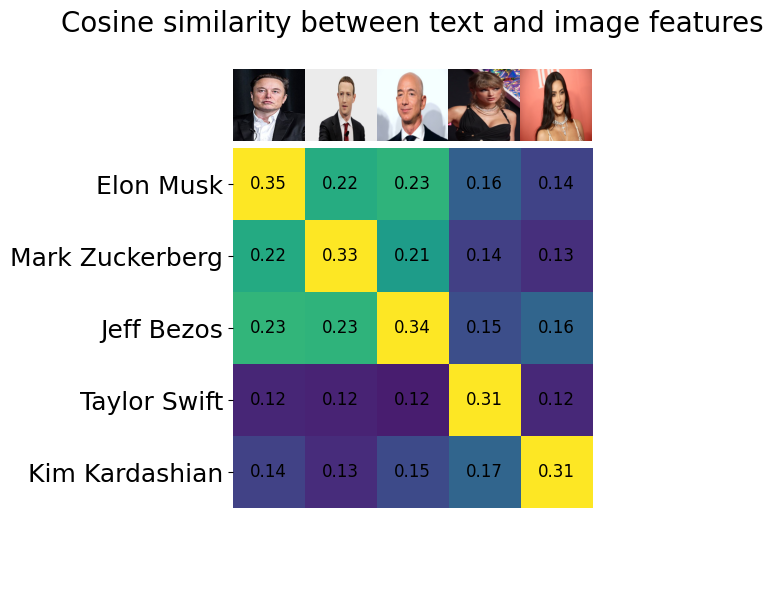

/tmp/ipykernel_10826/3653253312.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


Celeb classification for Elon_Musk: top1: 100.00, top5: 100.00
Celeb classification for Mark_Zuckerberg: top1: 95.00, top5: 95.00
Celeb classification for Jeff_Bezos: top1: 100.00, top5: 100.00
Celeb classification for Taylor_Swift: top1: 16.00, top5: 100.00
Celeb classification for Kim_Kardashian: top1: 80.95, top5: 90.48


In [18]:
urls = [
    "https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Elon_Musk_Colorado_2022_%28cropped2%29.jpg/220px-Elon_Musk_Colorado_2022_%28cropped2%29.jpg",\
    # "https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Mark_Zuckerberg_F8_2019_Keynote_%2832830578717%29_%28cropped%29.jpg/220px-Mark_Zuckerberg_F8_2019_Keynote_%2832830578717%29_%28cropped%29.jpg",\
    "https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcToA87dFnKkkn7smBpTGguPNZ-2HJz3XGhiXNrvtybCGWLT869i",\
    # "https://upload.wikimedia.org/wikipedia/commons/thumb/0/03/Jeff_Bezos_visits_LAAFB_SMC_%283908618%29_%28cropped%29.jpeg/220px-Jeff_Bezos_visits_LAAFB_SMC_%283908618%29_%28cropped%29.jpeg",\
    # "https://en.wikipedia.org/wiki/File:Jeff_Bezos_visits_LAAFB_SMC_(3908618)_(cropped).jpeg",\
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRwhgRcyw94DdjP5cXCFSdC9oIlvc447C-GEqeeJlnRKrQ9RwVd",\
    "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Taylor_Swift_at_the_2023_MTV_Video_Music_Awards_%283%29.png/220px-Taylor_Swift_at_the_2023_MTV_Video_Music_Awards_%283%29.png",\
    # "https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Kim_Kardashian_West_2014.jpg/1200px-Kim_Kardashian_West_2014.jpg"\
    # "https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Kim_Kardashian_West_2014.jpg/220px-Kim_Kardashian_West_2014.jpg"
    # "https://cdn.britannica.com/42/184142-050-5B50BDC2/Kim-Kardashian-2008.jpg"
    "https://variety.com/wp-content/uploads/2023/10/GettyImages-1485742278.jpg?w=1024"
]
texts = ["Elon Musk", "Mark Zuckerberg", "Jeff Bezos", "Taylor Swift", "Kim Kardashian"]

original_images = []
images = []
for url, name in zip(urls, texts):
    image = Image.open(requests.get(url, stream=True).raw)
    image = image.convert('RGB')
    # save_path = f"figs/name/{name}.jpg"
    # image.save(save_path)
    
    original_images.append(image)
    images.append(image)
# image_input = torch.tensor(np.stack(images)).cuda()
# text_tokens = tokenizer(["This is " + desc for desc in texts]).cuda()
# text_tokens = tokenizer(texts).cuda()

with torch.no_grad(), torch.cuda.amp.autocast():
    inputs = processor_clip(text=texts, images=images, return_tensors="pt", padding=True).to(device)
    outputs = model_clip_pretrained(**inputs)

    # image_features = model_pretrained.encode_image(image_input)
    # text_features = model_pretrained.encode_text(text_tokens)
    # image_features /= image_features.norm(dim=-1, keepdim=True)
    # text_features /= text_features.norm(dim=-1, keepdim=True)
    image_features = outputs.image_embeds
    text_features = outputs.text_embeds
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T


plot_iamge_text_matrix(similarity, texts, original_images, title="Cosine similarity between text and image features")


# evaluate quantitative
for name in texts:
    name = name.replace(' ', '_')
    top1, top5 = run_name(model_clip_pretrained, classifier_celeb, name, processor_clip, device)
    print(f"Celeb classification for {name}: top1: {top1*100:.2f}, top5: {top5*100:.2f}")

# top1, top5 = run(model_pretrained, classifier_imagenet, data_imagenet.dataloader, args)
# print(f"imagenet zeroshot top1: {top1*100:.2f}%, top5: {top5*100:.2f}%")

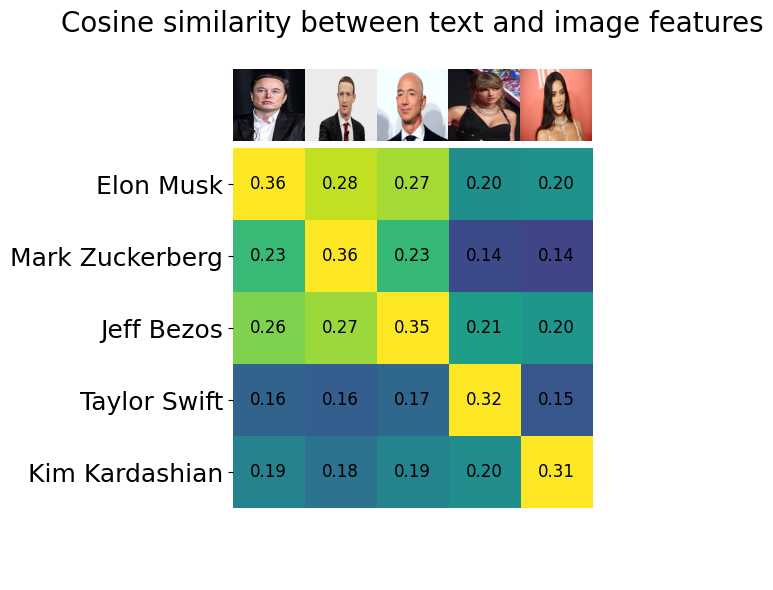

/tmp/ipykernel_3536/3653253312.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


Celeb classification for Elon_Musk: top1: 100.00, top5: 100.00
Celeb classification for Mark_Zuckerberg: top1: 95.00, top5: 95.00
Celeb classification for Jeff_Bezos: top1: 100.00, top5: 100.00
Celeb classification for Taylor_Swift: top1: 16.00, top5: 100.00
Celeb classification for Kim_Kardashian: top1: 80.95, top5: 90.48


In [199]:
with torch.no_grad(), torch.cuda.amp.autocast():
    inputs = processor_clip(text=texts, images=images, return_tensors="pt", padding=True).to(device)
    outputs = model_clip(**inputs)

    image_features = outputs.image_embeds
    text_features = outputs.text_embeds
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T


plot_iamge_text_matrix(similarity, texts, original_images, title="Cosine similarity between text and image features")


# evaluate quantitative
for name in texts:
    name = name.replace(' ', '_')
    top1, top5 = run_name(model_clip, classifier_celeb, name, processor_clip, device)
    print(f"Celeb classification for {name}: top1: {top1*100:.2f}, top5: {top5*100:.2f}")

In [20]:
# load stable diffusion models and run


import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

/home/exouser/miniconda3/envs/mu/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


In [21]:
pipe_pretrained = deepcopy(pipe)

In [22]:
pipe = deepcopy(pipe_pretrained)

### Edit the model
# Replace the model in the pipeline
# Note: Stable Diffusion 2 is a latent diffusion model conditioned on the penultimate text embeddings of a CLIP ViT-H/14 text encoder. 

for idx, (n,p) in enumerate(pipe.text_encoder.text_model.named_parameters()):
    # p.data = model_clip.text_model.get_parameter(n)
    p.data = model_clip.text_model.get_parameter(n).half()

# cast to float16
# pipe.text_encoder.text_model = pipe.text_encoder.text_model.half()

# do not mess with the tokenizer
# pipe.tokenizer = processor_clip.tokenizer

In [23]:
pipe = pipe.to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 23.24it/s]


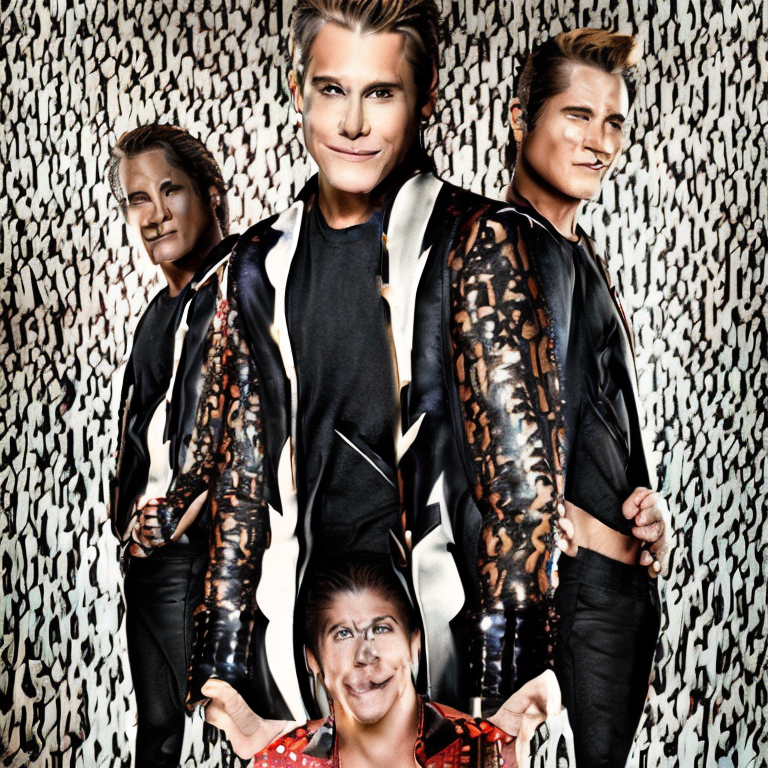

In [26]:
# Run evaluation

# prompt = "Elon Musk"
# prompt = "Elon Musk and his wife"
# prompt = "Mark Zuckerberg and his wife"

# prompt = "a portrait of Bruce Lee"
# prompt = "a portrait of Xi Jinping"
# prompt = "a portrait of Barack Obama"
# prompt = "a portrait of Taylor Swift"
# prompt = "a portrait of Kim Kardashian"
# prompt = "a portrait of Kanye West"

# prompt = "Kanye West and his wife"

prompt = "A portrait photo of Taylor Swift"
# prompt = "Taylor Swift singing"
# prompt = "A portrait of Jeff Bezos"
# prompt = "Jeff Bezos in a car"

# prompt = "Jeff Bezos on Mars"

# prompt = "A portrait photo of Elon Musk"
# prompt = "Elon Musk on Mars"
# prompt = "A portrait photo of Mark Zuckerberg"
# prompt = "A photo of an astronaut riding a horse on mars"
# prompt = "A cute cat jumping on a bed"
# prompt = "A sea turtle in the ocean"



# prompt = "an avocado chair"
# prompt = "an avocado"
# prompt = "an orange"
# prompt = "a chair"

# prompt = "a portrait of a chair"

# prompt = "iron man"
# prompt = "iron man and spiderman"
# prompt = "a piece of iron"

# prompt = "a mickey mouse"
# prompt = "a real mouse"
# prompt = "a mickey"
# prompt = 'Mickey Mouse'
# prompt = 'Mickey Mouse and friends'

image = pipe(prompt).images[0]

# image.save("astronaut_rides_horse.png")
image

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 23.19it/s]


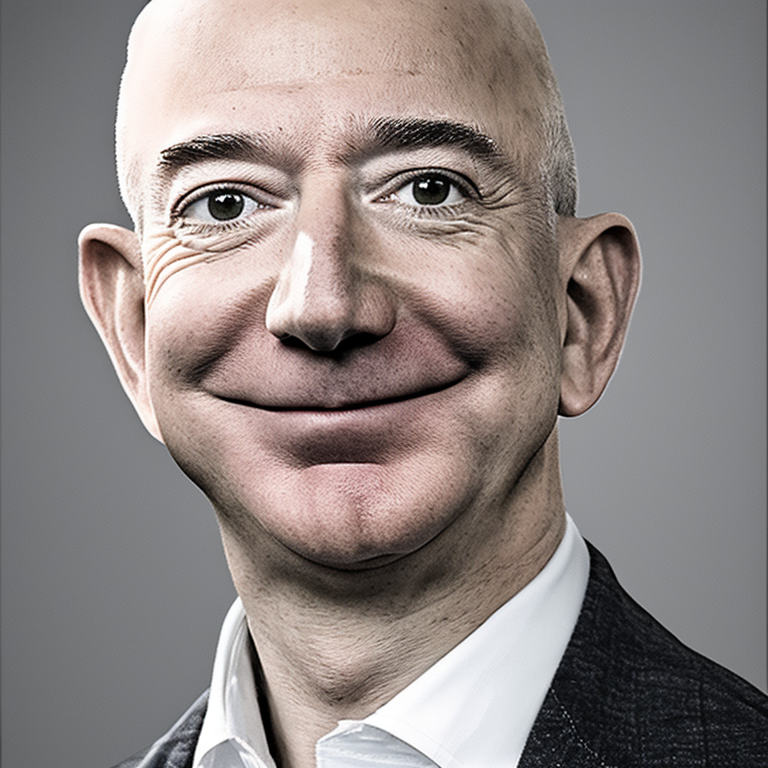

In [34]:
# Run evaluation

# prompt = "a photo of an astronaut riding a horse on mars"
# prompt = "a portrait of Elon Musk"
# prompt = "a portrait of Bruce Lee"
# prompt = "a portrait of Jinping Xi"
# prompt = "a portrait of Xi Jinping"

# prompt = "a portrait of Barack Obama"
# prompt = "a portrait of Taylor Swift"
# prompt = "a portrait of Kim Kardashian"
# prompt = "a portrait of Kanye West"
# prompt = "a portrait of Mark_Zuckerberg"

prompt = "a portrait photo of Jeff Bezos"

# prompt = "a cute dog"


image = pipe(prompt).images[0]

# image.save("astronaut_rides_horse.png")
image

In [94]:
# # avocado_chair
# prompt = "an avocado chair"
# for i in tqdm(range(500)):
#     image = pipe(prompt).images[0]
#     image.save(f"clip/figs/avocado_chair/avocado_chair_{i}.png")
#     with open(f'clip/figs/avocado_chair/avocado_chair_{i}.txt', "w") as file:
#         file.write(prompt)
        
# # iron_man
# prompt = "an iron man"
# for i in tqdm(range(500)):
#     image = pipe(prompt).images[0]
#     image.save(f"clip/figs/iron_man/iron_man_{i}.png")
#     with open(f'clip/figs/iron_man/iron_man_{i}.txt', "w") as file:
#         file.write(prompt)

# mickey_mouse
prompt = "Mickey Mouse"
for i in tqdm(range(500)):
    image = pipe(prompt).images[0]
    image.save(f"clip/figs/mickey_mouse/mickey_mouse_{i}.png")
    with open(f'clip/figs/mickey_mouse/mickey_mouse_{i}.txt', "w") as file:
        file.write(prompt)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [21:06<00:00,  2.53s/it]


In [95]:
import os
import tarfile
from tqdm import tqdm

def convert_png_to_jpg(png_path):
    # Open the PNG image
    with Image.open(png_path) as img:
        # Convert to RGB
        rgb_img = img.convert('RGB')
        # Save as JPG
        jpg_path = png_path.with_suffix('.jpg')

        # old_prefix = Path('/data/SalmanAsif')
        # new_prefix = Path('./data')
        # jpg_path = new_prefix / jpg_path.relative_to(old_prefix)

        rgb_img.save(jpg_path)
        return jpg_path



name = "mickey_mouse"

folder_path = f"clip/figs/{name}"
# tar_save_path = Path(f"clip/data/names/")
tar_save_path = Path(f"data/laion/forget/names/")

# folder_path = f"./data/laion/laion400m_celeba/{name}"
# tar_save_path = Path(f"./data/laion/forget/names/")
tar_save_path.mkdir(parents=True, exist_ok=True)

# img_save_path = Path(f"data/laion/laion400m_obj/{name}")
# img_save_path.mkdir(parents=True, exist_ok=True)

# List all files in the folder
files = os.listdir(folder_path)

# Group files by their base name (without extension)
file_groups = {}
for file in files:
    base_name, ext = os.path.splitext(file)
    if base_name not in file_groups:
        file_groups[base_name] = []
    file_groups[base_name].append(file)

# Create a TAR file to store the data
# with tarfile.open("/home/eegrad/zcai/unlearn/data/elon.tar", "w") as tar:
with tarfile.open(tar_save_path/f"{name}.tar", "w") as tar:
    # Iterate over each base name group
    for base_name, group_files in tqdm(file_groups.items()):
        # Ensure both image and text files are present for each base name
        if len(group_files) == 2:
            image_file = None
            text_file = None
            # Find image and text files
            for file in group_files:
                if file.endswith(".jpg") or file.endswith(".png"):
                    image_file = file
                elif file.endswith(".txt"):
                    text_file = file
            # If both image and text files are found, add them to the TAR file
            if image_file and text_file:
                image_path = os.path.join(folder_path, image_file)
                text_path = os.path.join(folder_path, text_file)
                # Convert PNG to JPG if necessary
                if image_file.endswith(".png"):
                    image_path = convert_png_to_jpg(Path(image_path))
                    image_file = image_path.name
                # Add image and text files to the TAR file with appropriate names
                tar.add(image_path, arcname=f"{image_file}")
                tar.add(text_path, arcname=f"{text_file}")
        else:
            image_file = None
            text_file = None
            for file in group_files:
                if file.endswith(".jpg"):
                    image_file = file
                elif file.endswith(".txt"):
                    text_file = file
            if image_file and text_file:
                image_path = os.path.join(folder_path, image_file)
                text_path = os.path.join(folder_path, text_file)                    
                
                tar.add(image_path, arcname=f"{image_file}")
                tar.add(text_path, arcname=f"{text_file}")        
            

print("TAR file created successfully.")

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:16<00:00, 30.37it/s]

TAR file created successfully.
